In [1]:
# Import necessary PySpark functions
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark import SparkFiles

# Initialize SparkSession
spark = SparkSession.builder.appName("Shakespeare").getOrCreate()

In [2]:
# add file URLs to dwonload into Spark Nodes
romeo = 'https://www.gutenberg.org/cache/epub/1513/pg1513.txt'
spark.sparkContext.addFile(romeo)

In [3]:
macbeth = 'https://www.gutenberg.org/cache/epub/1533/pg1533.txt'
spark.sparkContext.addFile(macbeth)

**Load files into DataFrame using spark.read.text**

In [10]:
df_romeo = spark.read.text(SparkFiles.get('pg1513.txt'))
df_romeo.show()

+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This ebook is for...|
|most other parts ...|
|whatsoever. You m...|
|of the Project Gu...|
|at www.gutenberg....|
|you will have to ...|
|before using this...|
|                    |
|Title: Romeo and ...|
|                    |
|Author: William S...|
|                    |
|Release date: Nov...|
|                M...|
|                    |
|   Language: English|
|                    |
|Credits: the PG S...|
+--------------------+
only showing top 20 rows



In [12]:
df.head(10)

[Row(value='The Project Gutenberg eBook of Romeo and Juliet'),
 Row(value='    '),
 Row(value='This ebook is for the use of anyone anywhere in the United States and'),
 Row(value='most other parts of the world at no cost and with almost no restrictions'),
 Row(value='whatsoever. You may copy it, give it away or re-use it under the terms'),
 Row(value='of the Project Gutenberg License included with this ebook or online'),
 Row(value='at www.gutenberg.org. If you are not located in the United States,'),
 Row(value='you will have to check the laws of the country where you are located'),
 Row(value='before using this eBook.'),
 Row(value='')]

In [11]:
df_macbeth = spark.read.text(SparkFiles.get('pg1533.txt'))
df_macbeth.show()

+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This ebook is for...|
|most other parts ...|
|whatsoever. You m...|
|of the Project Gu...|
|at www.gutenberg....|
|you will have to ...|
|before using this...|
|                    |
|      Title: Macbeth|
|                    |
|Author: William S...|
|                    |
|Release date: Nov...|
|                M...|
|                    |
|   Language: English|
|                    |
|Credits: the PG S...|
+--------------------+
only showing top 20 rows



**Seperate the Words**

The DataFrame will start with one line of text per row. Split out the words into one word per row.
Remove punctuation from the grouped word counts (e.g. “way.” becomes “way”). This should happen prior to grouping words. (Hint: regular expressions can be helpful here.)Filter non-words: Remove spaces, ellipses, and other non-words.




In [18]:
from pyspark.sql.functions import col, split, explode, sum, lower, count, desc, lit


In [32]:
# split each line into words
words_romeo = df_romeo.select(F.explode(F.split(F.col("value"), "[\s\.\,\!\?\;\_\[\]\(\)]+")).alias("word"))
# lowercase each word for consistency
words_romeo = words_romeo.select(F.lower("word").alias("word"))
# filter empty words
words_romeo = words_romeo.filter(F.col("word")!= "")
# remove common words
common_words = {'for', 'at', 'the', 'in', 'a', 'an', 'and', 'i', 'to', 'of', 'is', 's'}
words_romeo = words_romeo.filter(~col("word").isin(common_words))

words_romeo.show()

+---------+
|     word|
+---------+
|  project|
|gutenberg|
|    ebook|
|    romeo|
|   juliet|
|     this|
|    ebook|
|      use|
|   anyone|
| anywhere|
|   united|
|   states|
|     most|
|    other|
|    parts|
|    world|
|       no|
|     cost|
|     with|
|   almost|
+---------+
only showing top 20 rows



Total word count: Output the total word count summarizing all plays.


In [33]:
words_romeo.count()

24052

Grouped word count: Group and tally each word present amongst all plays combined. Sort with the most frequent words first.

In [36]:
grouped_words_romeo = words_romeo.groupBy("word").count().orderBy(F.desc("count"))
grouped_words_romeo.show()
grouped_words_romeo.count()

+------+-----+
|  word|count|
+------+-----+
|   you|  361|
|  that|  360|
|    my|  355|
| romeo|  302|
|  with|  299|
|   not|  287|
|  thou|  277|
|  this|  265|
|    me|  264|
|    it|  242|
|    be|  226|
|   but|  185|
|juliet|  182|
|   thy|  170|
|    as|  166|
|  what|  163|
|  will|  156|
|   her|  153|
| nurse|  149|
|     o|  149|
+------+-----+
only showing top 20 rows



4369

Turn it all into a function

In [42]:
def romeo_wordcount (romeo):
    # Load text as df
    df_romeo = spark.read.text(SparkFiles.get('pg1513.txt'))

    # split text, filter empty words, & remove common words
    words_romeo = df_romeo.select(F.explode(F.split(F.col("value"), "[\s\.\,\!\?\;\_\[\]\(\)]+")).alias("word"))
    words_romeo = words_romeo.select(F.lower("word").alias("word"))
    words_romeo = words_romeo.filter(F.col("word")!= "")
    
    common_words = {'for', 'at', 'the', 'in', 'a', 'an', 'and', 'i', 'to', 'of', 'is', 's'}
    words_romeo = words_romeo.filter(~col("word").isin(common_words))

    # Get total word counts
    grouped_words_romeo = words_romeo.groupBy("word").count().orderBy(F.desc("count"))

    return words_romeo, grouped_words_romeo


Turn both plays into a function


In [51]:
# Set plays into a dictionary 
playfiles = {'Romeo & Juliet':'pg1513.txt',
            'Macbeth': 'pg1533.txt'}

def wordcount_all_plays(playname):
    df = spark.read.text(SparkFiles.get(playfiles[playname]))
    # split text, filter empty words, & remove common words
    words_df = df.select(F.explode(F.split(F.col("value"), "[\s\.\,\!\?\;\_\[\]\(\)]+")).alias("word"))
    words_df = words_df.select(F.lower("word").alias("word"))
    words_df = words_df.filter(F.col("word")!= "")
    words_df = words_df.filter(~col("word").isin(common_words))
    # define total word counts
    total_wordcount = words_df.count()

    # total counts per word
    per_word_df = words_df.groupBy("word").count()
    per_word_df = per_word_df.orderBy(desc("count"))
    per_word_df = per_word_df.select(lit(playname).alias("play"), col("word"), col("count"))  

    return per_word_df, total_wordcount


**Display Eveything**

In [61]:
# Initalize varible se to none that will eventially hold the combined dfs of word counts
all_wordcount_df = None

for playname in playfiles.keys():
    # Define word count for each play
    per_word_df, total_wordcount = wordcount_all_plays(playname)
    # Print the wordcount & show
    print(f"Total word count for {playname}: {total_wordcount}")
    per_word_df.show()

    # If statement for initialized variable all_wordcount_df
    if all_wordcount_df:
        all_wordcount_df = all_wordcount_df.union(per_word_df)
    else:
        all_wordcount_df = per_word_df
    

Total word count for Romeo & Juliet: 24052
+--------------+------+-----+
|          play|  word|count|
+--------------+------+-----+
|Romeo & Juliet|   you|  361|
|Romeo & Juliet|  that|  360|
|Romeo & Juliet|    my|  355|
|Romeo & Juliet| romeo|  302|
|Romeo & Juliet|  with|  299|
|Romeo & Juliet|   not|  287|
|Romeo & Juliet|  thou|  277|
|Romeo & Juliet|  this|  265|
|Romeo & Juliet|    me|  264|
|Romeo & Juliet|    it|  242|
|Romeo & Juliet|    be|  226|
|Romeo & Juliet|   but|  185|
|Romeo & Juliet|juliet|  182|
|Romeo & Juliet|   thy|  170|
|Romeo & Juliet|    as|  166|
|Romeo & Juliet|  what|  163|
|Romeo & Juliet|  will|  156|
|Romeo & Juliet|   her|  153|
|Romeo & Juliet| nurse|  149|
|Romeo & Juliet|     o|  149|
+--------------+------+-----+
only showing top 20 rows

Total word count for Macbeth: 17782
+-------+-------+-----+
|   play|   word|count|
+-------+-------+-----+
|Macbeth|macbeth|  285|
|Macbeth|    you|  273|
|Macbeth|   that|  239|
|Macbeth|   with|  206|
|Macbet

In [66]:
# Get total wordcount of all plays into a df
total_wordcount_df = all_wordcount_df.groupBy("word").agg(sum("count").alias("count"))
total_wordcount_df = total_wordcount_df.orderBy(desc("count"))
total_wordcount_df.show()

+-------+-----+
|   word|count|
+-------+-----+
|    you|  634|
|   that|  599|
|     my|  545|
|   with|  505|
|    not|  478|
|   this|  412|
|     it|  410|
|     be|  380|
|     me|  374|
|   thou|  365|
|    but|  306|
|  romeo|  302|
|macbeth|  285|
|    his|  284|
|     as|  266|
|   have|  263|
|   what|  262|
|     or|  259|
|     so|  245|
|     he|  243|
+-------+-----+
only showing top 20 rows



**Analyze with Pandas**

Display a word cloud with the top 50 words.

In [59]:
!pip install wordcloud matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 4.3 MB/s eta 0:00:00a 0:00:01


In [73]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [67]:
# Convert to Pandas df

pandas_df = total_wordcount_df.toPandas()

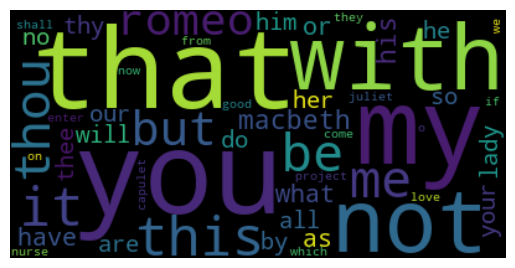

In [74]:
# calculate top 50 words
top_50_words = pandas_df.iloc[:50]
frequencies = pd.Series(top_50_words['count'].values,index=top_50_words['word']).to_dict()

wc = WordCloud()
wc.generate_from_frequencies(frequencies)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Create a histogram of word counts.


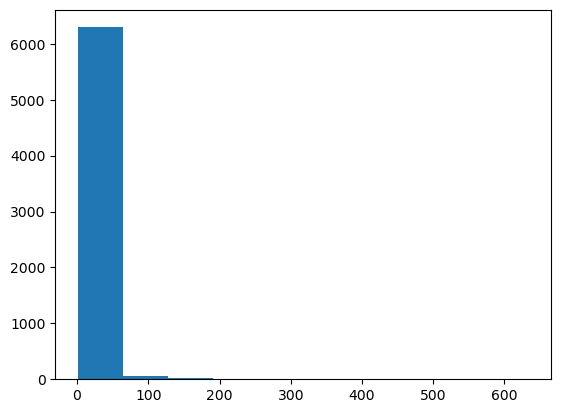

In [75]:
plt.hist(pandas_df['count'])
plt.show()